In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [33]:
train_df = pd.read_csv("child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("child-mind-institute-problematic-internet-use/test.csv")

In [34]:
train_df = train_df.dropna(subset=['sii'])

In [35]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
def IncorrectRows(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train_df['recal_sii'] = train_df.apply(IncorrectRows, axis=1)

In [36]:
mismatch_rows = train_df[
    (train_df['recal_sii'] != train_df['sii']) & train_df['sii'].notna()
]
mismatch_indexes = mismatch_rows.index
train_df = train_df.drop(mismatch_indexes)
train_df = train_df.drop(['recal_sii'], axis=1)

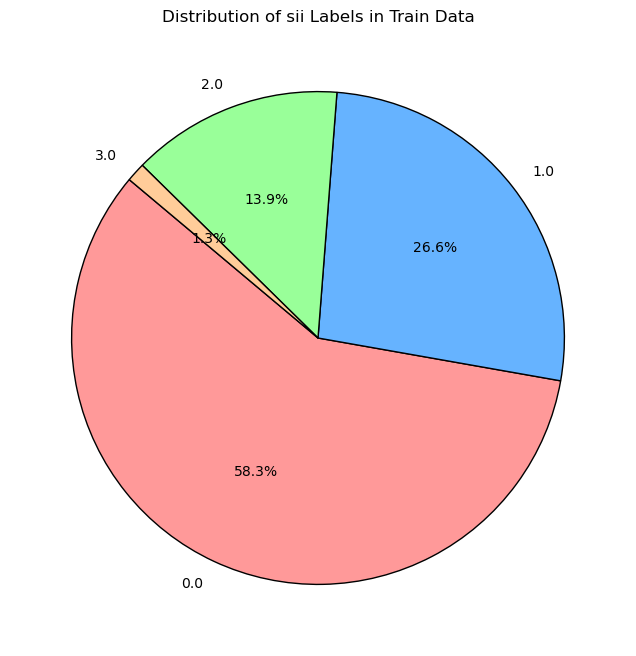

In [ ]:


# 自動取得各類別的數量
sizes = train_df['sii'].value_counts()
labels = sizes.index.astype(str)  # 將標籤轉為字串格式方便顯示
sizes = sizes.values  # 提取類別數量

# 畫圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of sii Labels in Train Data')
plt.show()


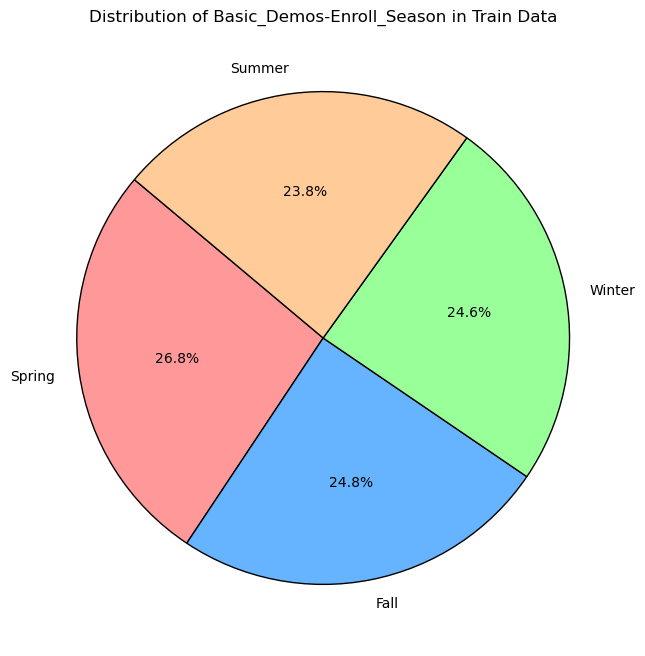

In [38]:
# 自動取得各類別的數量
sizes = train_df['Basic_Demos-Enroll_Season'].value_counts()
labels = sizes.index.astype(str)  # 將標籤轉為字串格式方便顯示
sizes = sizes.values  # 提取類別數量

# 畫圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Basic_Demos-Enroll_Season in Train Data')
plt.show()

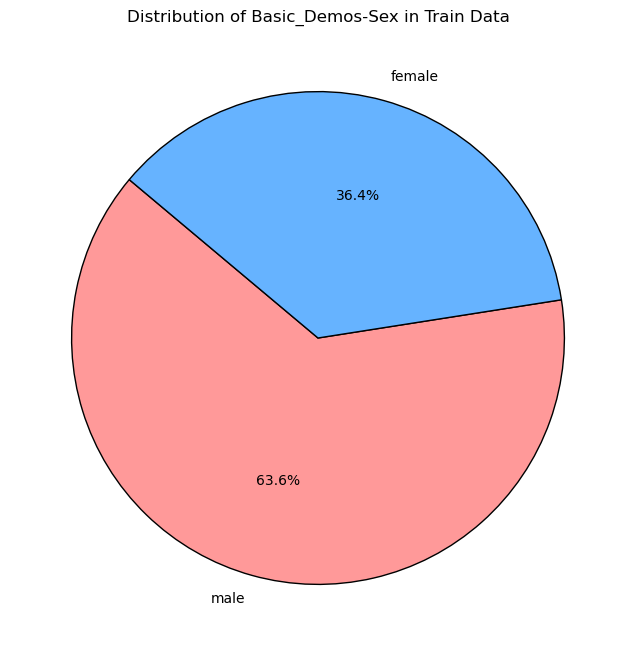

In [39]:
sex_mapping = {0 : 'male', 1 : 'female'}
train_df['Basic_Demos-Sex'] = train_df['Basic_Demos-Sex'].map(sex_mapping)
sex_count = train_df['Basic_Demos-Sex'].value_counts()
labels = sex_count.index.astype(str)
sex_count = sex_count.values  

# 畫圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(sex_count, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'], wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Basic_Demos-Sex in Train Data')
plt.show()

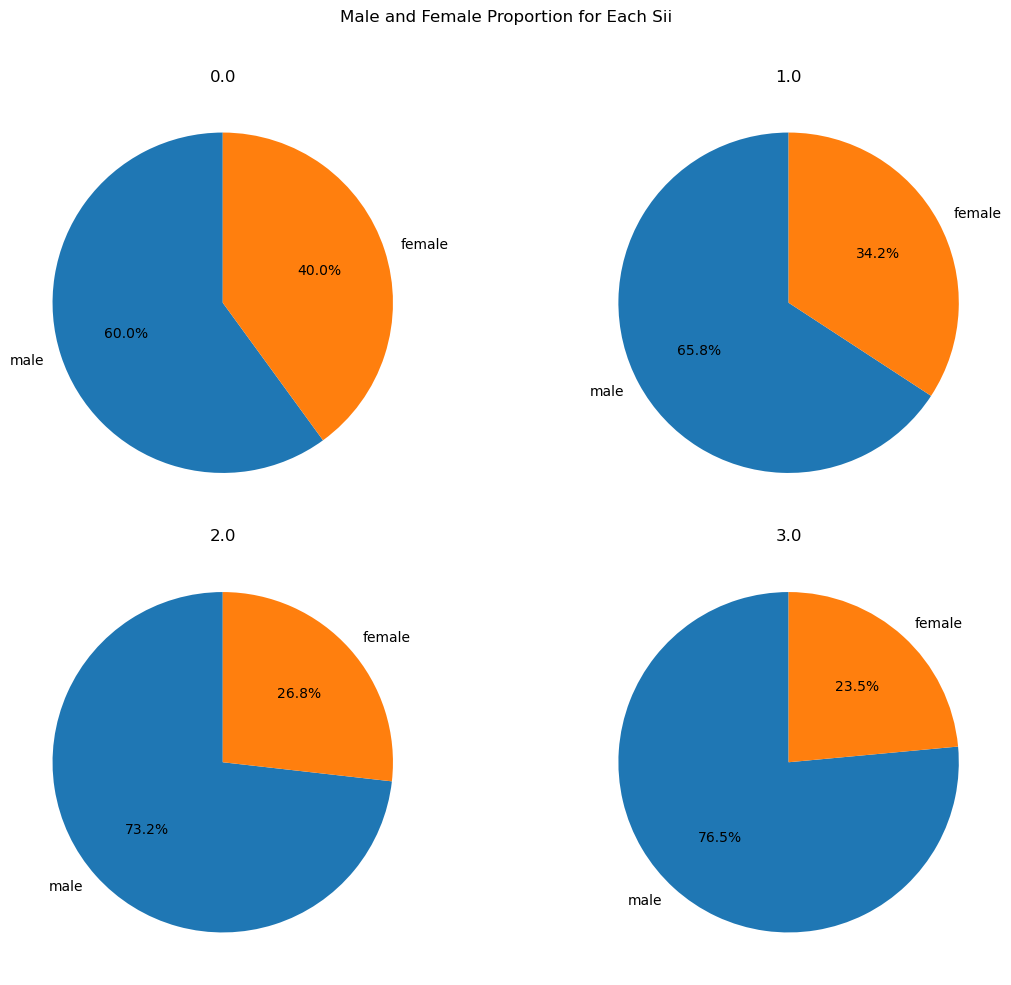

In [40]:
# 設置圖表的大小
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Male and Female Proportion for Each Sii")

# 定義每個target的名稱（根據你的資料設置）
target_labels = ["0.0", "1.0", "2.0", "3.0"]

# 迴圈每個 target，畫出性別比例的圓餅圖
for i, target in enumerate([0, 1, 2, 3]):
    # 選擇與target對應的資料
    data = train_df[train_df['sii'] == target]
    
    # 計算男性和女性的數量
    gender_counts = data['Basic_Demos-Sex'].value_counts()
    
    # 確定子圖位置
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # 畫出圓餅圖
    ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(target_labels[i])

# 調整子圖間距
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # 調整大標題和子圖之間的間距
plt.show()


In [41]:
# 建立反向映射字典
reverse_sex_mapping = {'male': 0, 'female': 1}

# 使用 map 函數將文字標籤映射回數值
train_df['Basic_Demos-Sex'] = train_df['Basic_Demos-Sex'].map(reverse_sex_mapping)
corr_matrix = train_df[['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
                        'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                        'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
                        'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
                        'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 
                        'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 
                        'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 
                        'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                        'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 
                        'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']].corr()
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

print(filtered_corr)

Basic_Demos-Age                           0.410153
Physical-BMI                              0.240281
Physical-Height                           0.421205
Physical-Weight                           0.353618
Physical-Waist_Circumference              0.324571
Physical-Systolic_BP                      0.147066
PreInt_EduHx-computerinternet_hoursday    0.373430
SDS-SDS_Total_T                           0.238541
FGC-FGC_CU                                0.288407
FGC-FGC_GSND                              0.147509
FGC-FGC_GSD                               0.161007
FGC-FGC_PU                                0.197464
FGC-FGC_TL                                0.137049
BIA-BIA_BMI                               0.246042
BIA-BIA_FFMI                              0.109590
BIA-BIA_Frame_num                         0.192015
Name: PCIAT-PCIAT_Total, dtype: float64


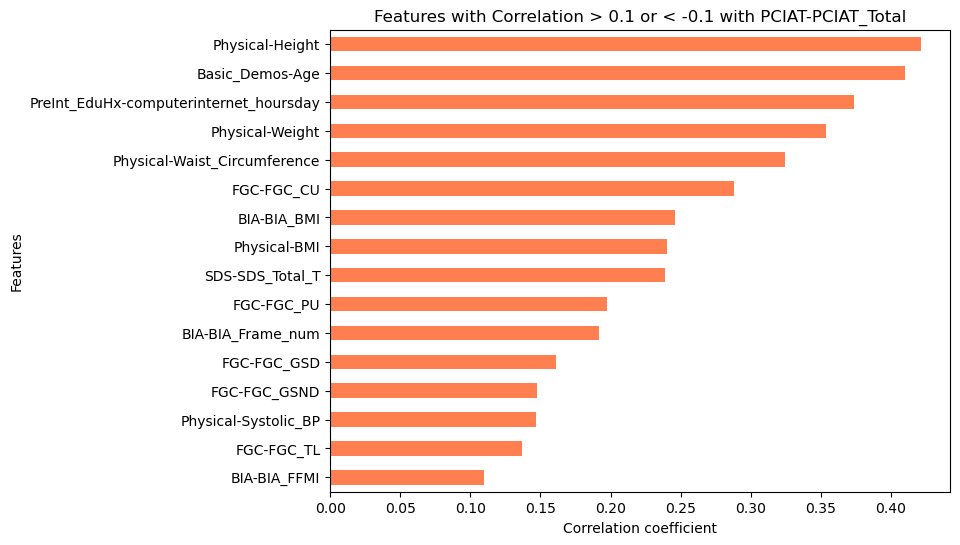

In [42]:
plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

In [44]:
assert train_df['Basic_Demos-Age'].isna().sum() == 0
#assert train_df['Basic_Demos-Sex'].isna().sum() == 0

In [45]:
bins = [4, 12, 18, 22]
# 定義區間標籤
labels = ['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']

# 將年齡數據分配到區間
train_df['Age_Group'] = pd.cut(train_df['Basic_Demos-Age'], bins=bins, labels=labels)
age_count = train_df['Age_Group'].value_counts()

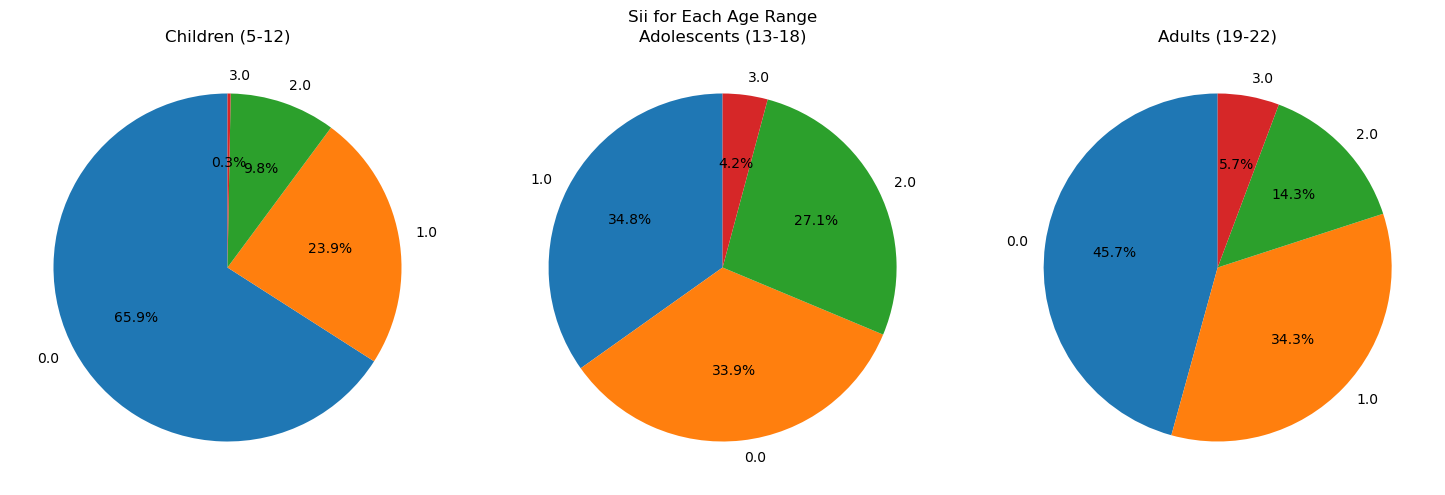

In [46]:
import matplotlib.pyplot as plt

# 定義年齡區間
bins = [4, 12, 18, 22]
# 定義區間標籤
labels = ['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']

# 將年齡數據分配到區間
train_df['Age_Group'] = pd.cut(train_df['Basic_Demos-Age'], bins=bins, labels=labels)

# 計算每個年齡區間的分佈
age_count = train_df['Age_Group'].value_counts()

# 設置圖表的大小，這裡設置為 1 行 3 列的子圖佈局
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Sii for Each Age Range")

# 迴圈處理每個年齡區間
for i, age_group in enumerate(labels):
    # 根據年齡區間篩選資料
    data = train_df[train_df['Age_Group'] == age_group]
    
    # 計算不同 sii 值的數量
    sii_counts = data['sii'].value_counts()
    
    # 取得對應的子圖
    ax = axes[i]
    
    # 畫出圓餅圖
    ax.pie(sii_counts, labels=sii_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(age_group)

# 調整子圖間距
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # 調整大標題和子圖之間的間距
plt.show()


ValueError: could not convert string to float: 'Fall'